In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../"))

In [2]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

# from desc import set_device
# set_device("gpu")

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [4]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import *
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import *
from desc.vmec_utils import *
from desc.input_reader import *
from desc.continuation import *

print_backend_info()

DESC version=0.14.2+518.g1813f7d7d.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: CPU, with 6.46 GB available memory.


In [140]:
# eq = get("precise_QA")
res = 10
eq = Equilibrium(L=res, M=res, N=4)
obj = ObjectiveFunction(ForceBalance(eq), jac_chunk_size=1)
cons = get_fixed_boundary_constraints(eq)
cons += (FixParameters(eq, {"L_lmn": True}),)
cons = maybe_add_self_consistency(eq, cons)
con = ObjectiveFunction(cons)
obj = LinearConstraintProjection(obj, con)
obj.build(verbose=0)
J = obj.jac_scaled_error(obj.x())

In [141]:
eigvals, eigvecs = jnp.linalg.eig(J.T@J)

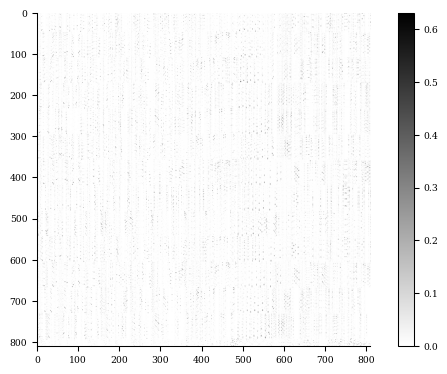

In [142]:
plt.imshow(abs(eigvecs.real), cmap="binary")
plt.colorbar()

In [143]:
for i in range(6):
    print(f"eigval {i}: {eigvals.real[-i]:.4e}")

eigval 0: 6.3627e+04
eigval 1: 3.9144e-03
eigval 2: 3.9144e-03
eigval 3: 3.9231e-03
eigval 4: 3.9231e-03
eigval 5: 1.9120e-03


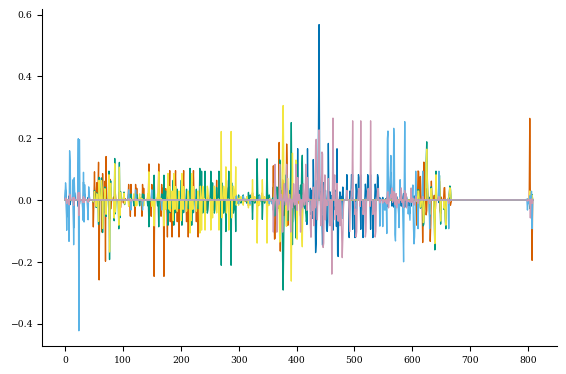

In [144]:
plt.plot(eigvecs.real[:,-6:])

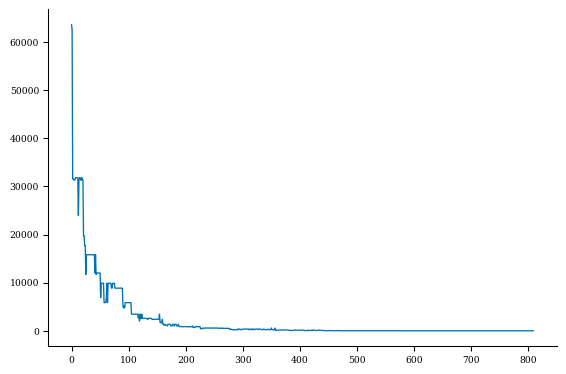

In [145]:
plt.plot(eigvals.real)

In [146]:
from desc.optimize.utils import compute_jac_scale

cond1 = jnp.linalg.cond(J)
scale2, _ = compute_jac_scale(J)
cond2 = jnp.linalg.cond(scale2*J)
cond3 = jnp.linalg.cond(J.T@J)
print(f"J    : {cond1:.2e}")
print(f"d*J  : {cond2:.2e}")
print(f"JTJ  : {cond3:.2e}")

J    : 8.98e+05
d*J  : 5.75e+05
JTJ  : 8.07e+11


In [147]:
from desc.optimize.utils import chol, solve_triangular_regularized

J_h = J*scale2
f = obj.compute_scaled_error(obj.x())
U, s, Vt = jnp.linalg.svd(J_h, full_matrices=False)
step_svd = scale2*(Vt.T @ (1/s * (U.T @ f)))

Q1, R1 = qr(J_h, mode="economic")
step_qr = scale2*solve_triangular_regularized(R1, Q1.T @ f)

R = chol(J.T@J)
step_cho = cho_solve((R, True), J.T@f)

In [148]:
norm_f = jnp.linalg.norm(f)
print(f"{jnp.linalg.norm(J@step_svd-f)/norm_f:.4e}")
print(f"{jnp.linalg.norm(J@step_qr-f)/norm_f:.4e}")
print(f"{jnp.linalg.norm(J@step_cho-f)/norm_f:.4e}")

2.8458e-03
2.8458e-03
2.8458e-03


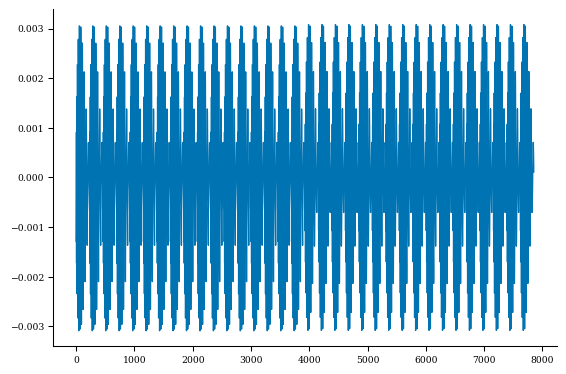

In [149]:
plt.plot(f)

Text(0.5, 1.0, 'Difference of Newton Steps for Different Methods and SVD')

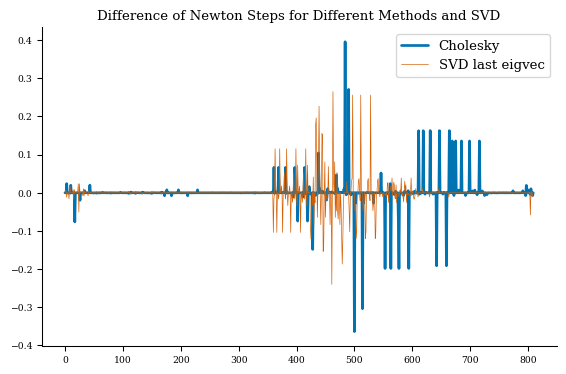

In [150]:
plt.plot((step_svd-step_cho)/jnp.linalg.norm(step_svd-step_cho), label="Cholesky", lw=2)
# plt.plot(step_svd-step_qr, label="QR", lw=0.5)
plt.plot(eigvecs.real[:,-1:], label="SVD last eigvec", lw=0.5)
plt.legend()
plt.title("Difference of Newton Steps for Different Methods and SVD")
# plt.savefig("compare-cho-error-eigvec.png", dpi=400)

In [151]:
jnp.linalg.norm(step_svd), jnp.linalg.norm(step_qr), jnp.linalg.norm(step_cho)

(Array(0.0514, dtype=float64),
 Array(0.0514, dtype=float64),
 Array(0.0514, dtype=float64))

In [152]:
max(step_svd-step_qr), max(step_svd-step_cho)

(Array(0., dtype=float64), Array(0., dtype=float64))

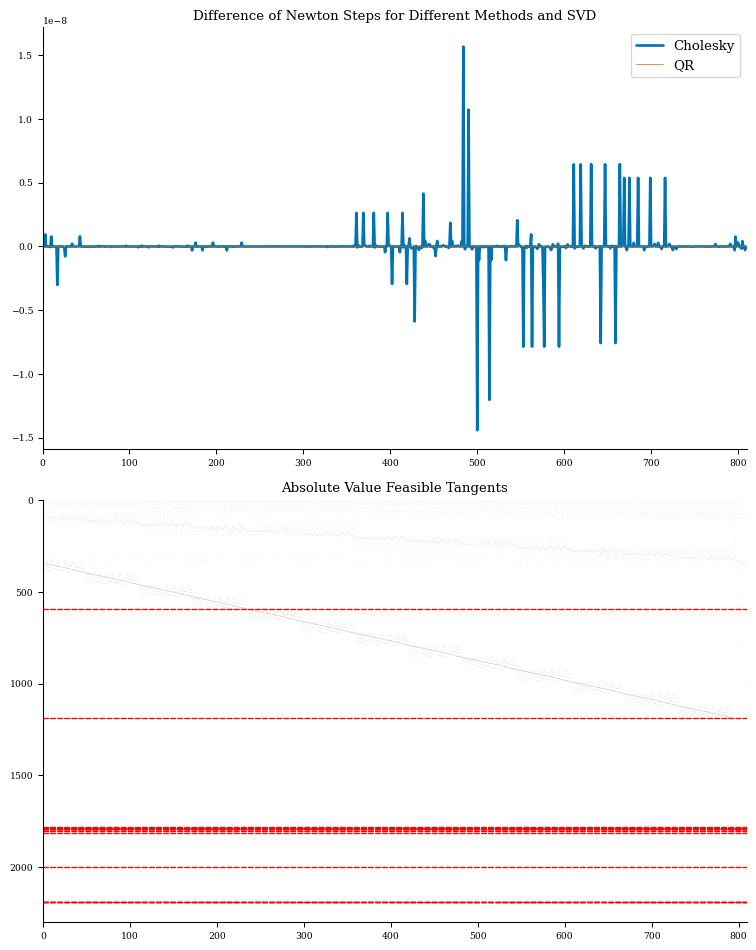

In [153]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False)
axs[0].plot(step_svd-step_cho, label="Cholesky", lw=2)
axs[0].plot(step_svd-step_qr, label="QR", lw=0.5)
axs[0].set_xlim(0, obj._feasible_tangents.shape[1])

axs[0].legend()
axs[0].set_title("Difference of Newton Steps for Different Methods and SVD")

im = axs[1].imshow(jnp.abs(obj._feasible_tangents), aspect="auto", cmap="binary")
axs[1].set_title("Absolute Value Feasible Tangents")

size_total = 0
for key, value in eq.params_dict.items():
    size = value.size
    size_total += size
    axs[1].axhline(y=size_total, color='r', linestyle='--')

plt.tight_layout()
plt.savefig("transform-objective-Z-fixed-L.png", dpi=1000)

In [113]:
start = len(eq.x_idx["R_lmn"]) + len(eq.x_idx["Z_lmn"]) - len(eq.x_idx["Rb_lmn"]) - len(eq.x_idx["Zb_lmn"])
end = start + len(eq.x_idx["L_lmn"])
L_idx = jnp.arange(start, end)
J_without_L = jnp.delete(J, L_idx, axis=1)
J_just_L = J[:, L_idx]
J_without_L.shape, J_just_L.shape, J.shape

((5346, 476), (5346, 380), (5346, 856))

In [114]:
scale1, _ = compute_jac_scale(J_without_L)
cond1 = jnp.linalg.cond(scale1*J_without_L)
cond2 = jnp.linalg.cond(J)
cond3 = jnp.linalg.cond(J_just_L)
print(f"J_without_L       : {cond1:.2e}")
print(f"J                 : {cond2:.2e}")
print(f"J_just_L          : {cond3:.2e}")

J_without_L       : 2.55e+04
J                 : 3.87e+07
J_just_L          : 2.27e+04


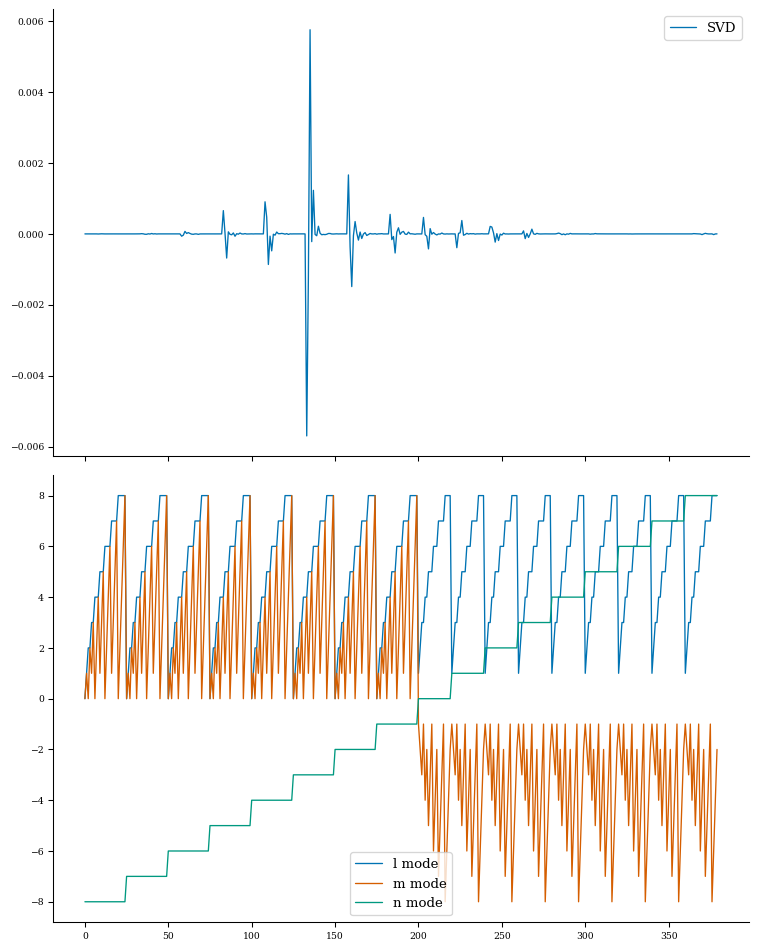

In [115]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# axs[0].plot(diff_cho[start:end], label="SVD - Cholesky", lw=2)
axs[0].plot(step_svd[start:end], label="SVD", lw=1)
# axs[0].plot(step_qr[start:end], label="QR", lw=1)
# axs[0].plot(step_cho[start:end], label="CHO", lw=0.5)
axs[1].plot(eq.L_basis.modes[:, 0], label="l mode")
axs[1].plot(eq.L_basis.modes[:, 1], label="m mode")
axs[1].plot(eq.L_basis.modes[:, 2], label="n mode")
axs[0].legend()
axs[1].legend()
# fig.savefig("difference-modes.png", dpi=400)